# Convolution Neural Networks

Let's begin by loading some of the tools we will need to this job. We will utilize Keras for building/training our neural network and matplotlib for plotting and visualization, and numpy for *everything* (period).

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

Using TensorFlow backend.


## The Data

Let's use one of the most common image data sets used to benchmark convolution network implementations: MNIST. We explored it some in other introductions, so I'll let is speak for itself this time around. Please see the Single- and Multi-layer tutorials before attempting this one...

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)

(60000, 28, 28)

(60000,)

(10000, 28, 28)

(10000,)

In [3]:
## Standardize the -input- data between 0.0-1.0 (real)
## instead of the default 0-255 (integer)
x_train = x_train.astype('float32').reshape(x_train.shape+(1,))
x_test = x_test.astype('float32').reshape(x_test.shape+(1,))
x_train /= 255
x_test /= 255

# Convert class vector [0-9] to categorical assignments (one-hot)
y_train = keras.utils.to_categorical(y_train, len(np.unique(y_train)))
y_test = keras.utils.to_categorical(y_test, len(np.unique(y_test)))

display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)

(60000, 28, 28, 1)

(60000, 10)

(10000, 28, 28, 1)

(10000, 10)

Remember that these are greyscale images, so there is just a single intensity value for each pixel. Full color images would need to have *3* channels (red, green, blue) for processing. Even though this is the case, Keras `Conv2D` layers expect that images have *three* dimensions (3D tensors) and so you must explicitly set this third dimension to 1 for it to accept each image as input. The `reshape()` function is used to add this extra dimension (wich a size of 1) to the existing data tensors.

In [4]:
model = keras.Sequential()
# Note the input size (there is only one channel - intensity)
# these images... if you are using color images, your would
# need to set the last dimension of the input_shape to -3-
# above and this would carry over into this cell...
model.add(keras.layers.Conv2D(64, kernel_size=(8, 8),
                              activation='relu',
                              input_shape=[x_train.shape[1],
                                           x_train.shape[2],
                                           x_train.shape[3]]))
model.add(keras.layers.Conv2D(128, (8, 8), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 21, 21, 64)        4160      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       524416    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

This is a pretty big network, no? Over 1 million connection weights! The convolution layers are applied twice over over the image before applying a pooling step, so the number of units *even after pooling* is quite large. Once flattened, this creates a large set of weights to the immediate dense layer which follows. The result is funneled into a smaller layer before using a softmax layer to categorize the image. 

## Counting Connection Weights...
Before moving on, let's unpack some of the output from the `summary()` function to understand what has happened here. There are a lot of weights, so it's worth thinking about what they are doing and where they came from.

First, the initial `Conv2D` layer has 4160 parameters (connection weights). We selected a layer size of `64` when making the layer, so we are create 64 different *feature detector* units which we will slide around (convolve with) the image in order to detect this feature anywhere in the image. Each unit gets its own bias weight, so there are 4096 weights left unaccounted for. Each feature detector was requested to make a `kernel_size` of 8 x 8 pixels (that's 64 weights for each unit) and so 64 x 64 = 4096. All weights for this layer are now accounted for. The same weights are used at each 8 x 8 patch in the image (overlapping and crossing) because we want each unit to become a dedicated *feature detector* during the learning process.

However, that also means there are 21 x 21 unique 8 x 8 patches within this image, so that each unit calculates an activation value for each of the 441 (21 x 21) locations, but these activation patterns stay arranged in a 21 x 21 grid just like a 2D image. This means that the output for this layer is 21 x 21 x 64 in size... getting big, right?

Now, for the second `Conv2D` layer, there are 524416 weights (WOW!). So, how do we account for all of those weights? Well, first we again start with the number of units requested, in this case 128. Each has a single bias weight, which leaves us with 524288 weights unaccounted for so far. There is again an 8 x 8 kernel requested at this layer, so each unit has a set of 64 weights assigned to it, but only within *one* of the 21 x 21 grids from the previous layer (and there are 64 of them). So, 64 (kernel weights) x 128 (units) x 64 (prev units) = 524288, and all weights are now accounted for. Finally, each of these 128 units is being slid across the 21 x 21 grid from the previous layer using the 8 x 8 kernel, and there are 14 x 14 =  196 unique patches. Again, the 14 x 14 arrangement of the activation outputs is maintained for each of the 128 units to retain 2D structure. However, we have now created a double convolution (complex features detected as convolutions of simpler features).

We follow up with a `MaxPooling2D` layer with a kernel size of 2 x 2. This means that we downsample the 14 x 14 grids from the previous layer with *nonoverlapping* patches of 2 x 2, and retain the maximum in this region (because it's most likely that only *one* complex feature will be detected in any of these distinct patches). This also helps with reducing the size of the activations from the previous layer by half from 14 x 14 x 128 down to 7 x 7 x 128. An additional `Dropout()` layer is also added here to encourage the network to be robust to missing features (maybe forcing different units in the convolutional layers to be somewhat redundant).

The `Flatten()` layer is designed to remove the 2D structure of the activation (layer output) vectors at this point. Since we have 7 x 7 x 128 = 6272, it just reshapes the output from the previous layer into the flattened 1D vector of activations. This allows us to stack standard `Dense` and `Dropout` layers from now, but the calculating the number of connection weights is now much easier. For example, after the `Flatten` layer, we have a layer of 128 units (`Dense`), so the weight matrix contains 6272 x 128 + 128 [bias weights] = 802944 connection weights total. After an additional `Dropout` layer, we have a `Dense` layer of 10 units (the output layer), so 128 x 10 + 10 [bias] = 1290 connection weights. Therefore, all parameters can be accounted for in the convolution and flattening process.

It's important to think through this exercise to understand how the network is wired up if you plan to use convolution nets on your particular problem...

## Training Time

OK, hold up just one second. One thing you need to understand is that this is a *big* network and there is *a lot* of data moving through it. It's not large compared to what some research groups train these days, but working on a powerful desktop (even Biosim) will still require a *several* minutes to train it up. If you complete this cycle of training, you can expect > 98% accuracy on the testing data at the end of the day.

In [5]:
batch_size = 512
epochs = 5
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 144s 3ms/step - loss: 0.3760 - accuracy: 0.8820 - val_loss: 0.0771 - val_accuracy: 0.9758
Epoch 2/5
48000/48000 [==============================] - 142s 3ms/step - loss: 0.0988 - accuracy: 0.9710 - val_loss: 0.0585 - val_accuracy: 0.9818
Epoch 3/5
48000/48000 [==============================] - 141s 3ms/step - loss: 0.0669 - accuracy: 0.9798 - val_loss: 0.0457 - val_accuracy: 0.9863
Epoch 4/5
48000/48000 [==============================] - 140s 3ms/step - loss: 0.0522 - accuracy: 0.9847 - val_loss: 0.0375 - val_accuracy: 0.9885
Epoch 5/5
48000/48000 [==============================] - 141s 3ms/step - loss: 0.0428 - accuracy: 0.9870 - val_loss: 0.0368 - val_accuracy: 0.9893


In [6]:
# Final Result - Generalization!
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 23s 2ms/step
Test loss: 0.02521226280226401
Test accuracy: 0.9919999837875366


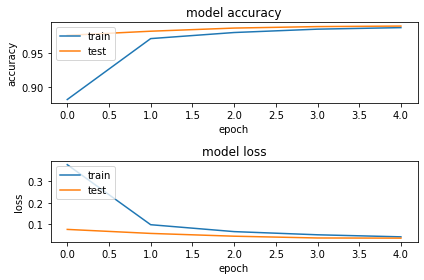

In [7]:
plt.figure(1)  
  
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left') 

plt.tight_layout()
plt.show()  

## Examining the Weights

Let's see if we can get a glimpse into what the network has learned by unpacking some of the weights in the network and plotting them. Since the kernel patches have a 2D structure to them, we would expect the network to start learning interesting 2D features which capture edges and common shapes in these small patches that can be stitched together to form composite digits. These features are what a convolution network is all about: changing the inductive bias of the network to better capture the kinds of features useful for classifying 2D/image data.

OK, so we can use the `get_weights()` function to grab them, and we expect 8 sets of them. This is because 4 layers in the network construction introduced connection weights (only four rows in the summary have a non-zero entry in #Params). Then, then connection weights and bias weights for each layer are divided into two separate tensors each. The connection weights will not be matrices since the addition of 2D structure rearranges them based on the selected kernel size.

Let's grab one set, and then many more...

In [8]:
# This is everything!
weights = model.get_weights()

In [9]:
# How many tensors?
len(weights)

8

In [10]:
# What's the shape of the tensor
# for the connection weights at
# the -first- Conv2D layer?
weights[0].shape

(8, 8, 1, 64)

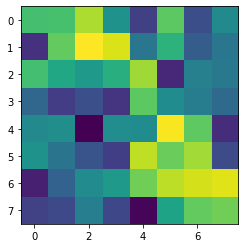

In [11]:
# We can plot the kernel weight matrix
# for just the first unit (out of 64)
# as an example...
plt.imshow(weights[0][:,:,0,0])
plt.show()

The light values indicate high weights, and the dark regions indicate low weights. In general, high weights cause a unit to turn on when pixel intensities are high and low weights cause a unit to turn off when pixel intensities are high. Therefore regions which transition from high to low weights are finding edges. Different units will detect different shape and orienations of these edge features, which form the basic building blocks for object detection and recognition. We can look at all 64 of the units by creating a plot with 64 small 8 x 8 subplots.

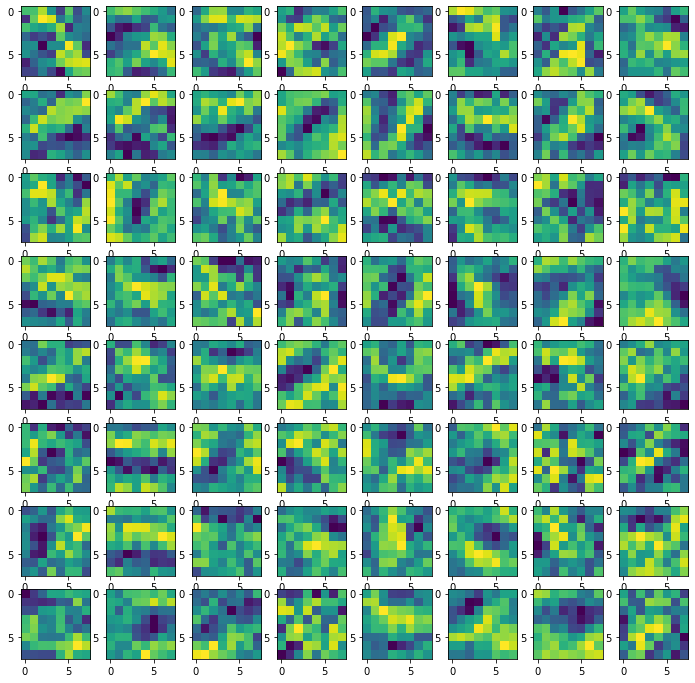

In [12]:
fig,axes = plt.subplots(8,8)
fig.set_figwidth(12)
fig.set_figheight(12)
for x in range(8):
    for y in range(8):
        data = weights[0][:,:,:,(x*8)+y].reshape(8,8)
        
        axes[x,y].imshow(data)
plt.show()

These edge features are  then combined at the next `Conv2D` layer to form more complex features, so they are detecting changes in observed features. 

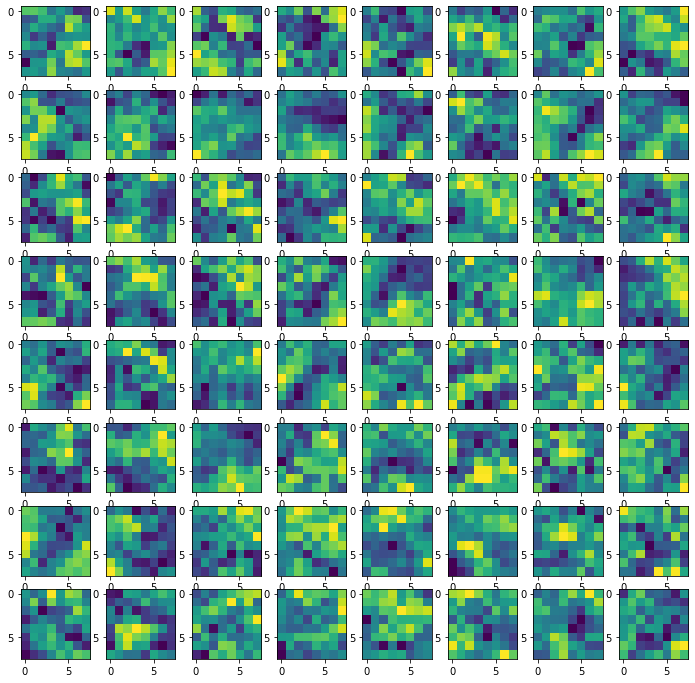

In [13]:
fig,axes = plt.subplots(8,8)
fig.set_figwidth(12)
fig.set_figheight(12)
for x in range(8):
    for y in range(8):
        axes[x,y].imshow(weights[2][:,:,(x*8)+y,1].reshape(8,8))
plt.show()

We've now built and trained a basic convolution neural network, but there's more on this to come soon!

## Using a Pre-trained Model (Transfer Learning)

Now that we have explored building a ConvNet from scratch using MNIST, let's explore two more potentially useful techniques:
1. 3-channel (R,G,B) images
2. Pre-trained ConvNet for early stages of processing

We will utilize full-color images (increasing the third dimension of our input tensors to 3). Images will be of a different size now as well since we will build the convolution layers of our network using a *pretrained* set of layers and connection weights which have already been trained on an extensive set of images. This is useful since we don't necessary have the time and memory resources to burn on training up the low-level features useful for generalized classification. Instead, we will exploit the pre-trained network topology and then stack some additional layers on top of these pre-trained layers to perform our *particular* categorization task. This should also allow for faster training of the network since we won't be updating the connection weights on the earlier layers of the network. This reduction in the number of weights that need to be updated by backprop will significantly reduce our training time on our image classification task of interest.

First though, we need to load up an image data set to use. This example will consist of 100 images borrowed from [ImageNet](http://www.image-net.org). I've already prepared the data set on the JupyterLab systems for this course in the shared directory `/home/shared/xception_example`. You can also download the data set from the JupyterLab systems (just browse to the `/home/shared` directory on any of the systems, and right click-download `exception-example.zip`). You will need to adjust some of the paths below if you decide to download the data yourself. Due to copyright restrictions, I am not going to post this data set on the course website, and some of the image processing tools that can read images from URLs directly were also performing some additional processing on the images that might not be compatible with this tutorial, so we won't use them until that gets fixed.

OK, let's load up some images and see what we have...

In [14]:
# First a few tools for this -particular- example...
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions

In [18]:
def grab_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

# Note - this only works on my local servers (see the path?)
# You will need to load a set of images from a -different- location if you would
# like to try this out if you are not on the CSCI 4850/5850 machines.
X = np.concatenate([grab_image('/nfshome/sandbox/xception_example/images/image_%d.JPEG'%(i)) for i in range(100)])
X.shape

(100, 299, 299, 3)

You will note that this is a *4D tensor* of input data for the network. The first dimension is 100 since there are 100 images, each image is 299 x 299 pixels (dims 2 and 3), and the last dimension is of size 3 for the three color channels of the image (red, green, blue). After the above code has been run, each image has already been preprocessed for input into the pre-trained network that we will be using: Googles's Xception net.

If you want to verify any of the images though, you can reconvert the preprocessed arrays *back* into an image format accepted by matplotlib, and use `imshow()` to display it.

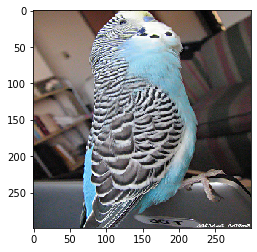

In [19]:
plt.imshow(image.array_to_img(X[0,:,:,:]))
plt.show()

In [20]:
# Let's load up the model
# This will load up the architecture
# and then the pre-trained weights from the
# internet...
model = Xception(weights='imagenet')
model.summary()

91889664/91884032 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________

That's a big network, no? Even though the network is very deep, the total number of parameters is only about 23 million, which is actually *very* compact and this is still an excellent network for image classification. Let's just use the default architecture and see what it says about the first image in our data set using the `predict()` method.

In [21]:
# Just the first image that we say above...
preds = model.predict(X[0:1,:,:,:])

# Decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=5)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n01817953', 'African_grey', 0.44841477), ('n01608432', 'kite', 0.037295144), ('n01819313', 'sulphur-crested_cockatoo', 0.016664201), ('n01798484', 'prairie_chicken', 0.010966346), ('n01807496', 'partridge', 0.010686282)]


That's pretty good. There are 1000 different categories used here, so lot's of different images will be categorized pretty well with at least one of the top 5 or so results. Here, the first hit at 44.8% is a very good fit even though it's not *really* an African Grey. Even the next 4 highest probabilities are all pretty close as well (never trained on this specific class anyway).

OK, so now we can use the model to make a class prediction, but let's see if we can use the pretrained network and build our own classifier on *top* of this model. In order to do this, we will need some different class labels for our data. For these 100 images, 37 have pictures of cats. Therefore, we are going to make a simple two-class predictor (cat vs. no-cat), but use Xception as the first part of our network. Let's load the class labels, and build a net with an Xception front-end.

In [22]:
# 37 cats in there (label 1, and all else 0)
Y = np.loadtxt('/nfshome/sandbox/xception_example/class_labels.csv')
Y = keras.utils.to_categorical(Y)

# Take a look at the first 10...
Y[0:10,:]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

Oh, so number 5 must be a cat picture, right?

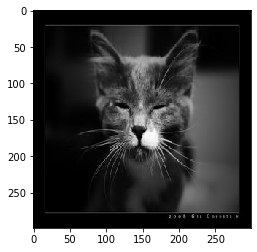

In [23]:
plt.imshow(image.array_to_img(X[4,:,:,:]))
plt.show()

In [24]:
# Build an Xception-based network

# Base Model
base_model = keras.applications.Xception(weights='imagenet',include_top=False)
# This model uses the trained weights, but critically,
# the include_top=False flag is provided to allow us to
# add our own layers at the top...

# New model that we are adding at the end...
# We will start by setting the -start- of the model
# to the -end- (output) of the pretrained model...
new_model = base_model.output

# Now, we can start adding our own layers to the model...
# Here, I am using the -functional- network model for
# Keras instead of the -sequential- model. This means we
# need to "manually" tie our layers together by creating
# them and then providing the upstream layer as an argument
# to the object's functional interface:
new_model = keras.layers.GlobalAveragePooling2D()(new_model)
# We are using an average pooling layer to select the most
# likely among the features provided by the base_network...

# Now, let's continue to stack layers into the model...
new_model = keras.layers.Dense(30,activation='relu')(new_model)

# Add the final output layer (just 2 classes)
new_model = keras.layers.Dense(2,activation='softmax')(new_model)

# For the functional model, we first build up a set of layers
# and network componenets, and then specify which of those
# layers and components function as the input and output for
# our model.
model = keras.Model(inputs=base_model.input,outputs=new_model)
# It's possible to have -multiple- input or output components
# for a model as well, but here we just use the Xception model's
# input layer and the output layer from our added layers as
# the output layer for the mode...

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# Take a quick look at it...
model.summary()

83689472/83683744 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________

We can see the extra layers stacked at the end that we made! Now we are ready to try to train this model up. Remember, this is another *big* model, so the training time is great, but it should still be better than starting from scratch.

In [25]:
batch_size = 20
epochs = 10
history = model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split = 0.4)
# 0.4 split size provides 25 cats in the training set,
# and 12 in the validation set...

Train on 60 samples, validate on 40 samples
Epoch 1/10
60/60 [==============================] - 103s 2s/step - loss: 0.5651 - accuracy: 0.7167 - val_loss: 0.5021 - val_accuracy: 0.7750
Epoch 2/10
60/60 [==============================] - 58s 959ms/step - loss: 0.1865 - accuracy: 0.9500 - val_loss: 1.8264 - val_accuracy: 0.5500
Epoch 3/10
60/60 [==============================] - 57s 951ms/step - loss: 0.0334 - accuracy: 1.0000 - val_loss: 3.4618 - val_accuracy: 0.5750
Epoch 4/10
60/60 [==============================] - 57s 946ms/step - loss: 0.0467 - accuracy: 0.9667 - val_loss: 2.3194 - val_accuracy: 0.7250
Epoch 5/10
60/60 [==============================] - 57s 942ms/step - loss: 0.2572 - accuracy: 0.9333 - val_loss: 2.6061 - val_accuracy: 0.7750
Epoch 6/10
60/60 [==============================] - 57s 950ms/step - loss: 0.0906 - accuracy: 0.9833 - val_loss: 3.1017 - val_accuracy: 0.8250
Epoch 7/10
60/60 [==============================] - 58s 959ms/step - loss: 0.2089 - accuracy: 0.9333

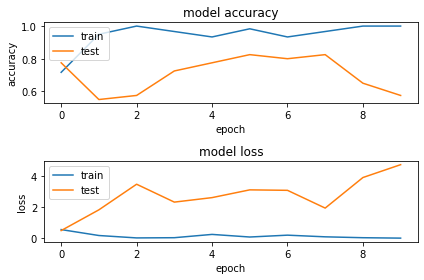

In [27]:
plt.figure(1)  
  
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left') 

plt.tight_layout()
plt.show()  

Well, we ended up with a *horrible* case of overfitting since the performance on the test cases is so bad, but we can at least get it to learn the training data (100%). We could, of course, add *dropout* or some other regularizeration method to try to cope with this, but we know for a fact that 60 images is a little data starved for this kind of task. So instead, let's just train up a conv net from scratch for 10 epochs for comparison, and see what it can do in that same amount of effort.

In [28]:
# A convolution net for the cat problem!
model = keras.Sequential()
# Three input channels this time!
model.add(keras.layers.Conv2D(64, kernel_size=(8, 8),
                              activation='relu',
                              input_shape=[X.shape[1],
                                           X.shape[2],
                                           X.shape[3]]))
model.add(keras.layers.Conv2D(128, (8, 8), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(8, 8)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(Y.shape[1], activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# Roughly the same number of parameters!
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 292, 292, 64)      12352     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 285, 285, 128)     524416    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 35, 35, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 156800)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               20070528  
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

In [29]:
batch_size = 20
epochs = 10
history = model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split = 0.4)

Train on 60 samples, validate on 40 samples
Epoch 1/10
60/60 [==============================] - 102s 2s/step - loss: 5.2073 - accuracy: 0.5833 - val_loss: 0.8751 - val_accuracy: 0.3000
Epoch 2/10
60/60 [==============================] - 75s 1s/step - loss: 0.7015 - accuracy: 0.4167 - val_loss: 0.6942 - val_accuracy: 0.3000
Epoch 3/10
60/60 [==============================] - 76s 1s/step - loss: 0.6936 - accuracy: 0.4333 - val_loss: 0.6936 - val_accuracy: 0.3000
Epoch 4/10
60/60 [==============================] - 77s 1s/step - loss: 0.6935 - accuracy: 0.3833 - val_loss: 0.6925 - val_accuracy: 0.7000
Epoch 5/10
60/60 [==============================] - 76s 1s/step - loss: 0.6928 - accuracy: 0.5500 - val_loss: 0.6916 - val_accuracy: 0.7000
Epoch 6/10
60/60 [==============================] - 76s 1s/step - loss: 0.6924 - accuracy: 0.5833 - val_loss: 0.6906 - val_accuracy: 0.7000
Epoch 7/10
60/60 [==============================] - 76s 1s/step - loss: 0.6915 - accuracy: 0.5833 - val_loss: 0.689

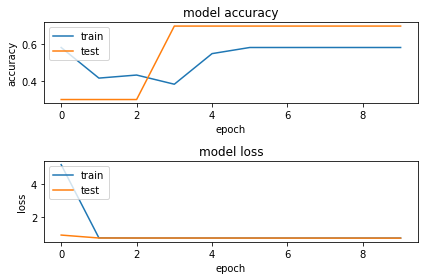

In [30]:
plt.figure(1)  
  
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left') 

plt.tight_layout()
plt.show()  

It may take a while to train these large networks, so starting from the pre-trained network is a *huge* advantage in most cases. Don't let the 70% test accuracy fool you on the "*from scratch*" network just above: we haven't even begun to decrease in loss for the training data, so it's not indication of future performance. Pre-trained networks (transfer learning) will likely become more and more common in future applications due to the large computational resources and careful tuning required for large-scale performance when training networks from scratch.